<center><h2> Key Frame Extraction</h2></center>

In this notebook, the key frame selection/extraction (KFE) of an RGB video taken as input is performed. The output after KFE are the video after removing redundant frames and a JSON file with important parameters. The parameters considered for KFE are hand distance and hand height. 

In [1]:
# Importing necessary libraries
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import mediapipe as mp
import statistics 
import json

**1. Finding Centroid**

    To calculate the parameters i.e., hand height and hand distance for the Key Frame Extraction process, the x and y cordinate of the centroid of both left and right hands are required. This is being calculated in the below function. 

In [2]:
# Function to find x and y cordinates of the centroid of left and right hands
def findCentroid(poseVideo, success, frame):
    # List to store x and y cordinates of right and left hand
    right_hand_x = []
    right_hand_y = []
    left_hand_x = []
    left_hand_y = []
    
    # Setting the right and left hand cordinates
    rightHandCords = [16, 18, 20, 22]
    leftHandCords = [15, 17, 21, 19]
    
    if success == True:
        # Recoloring the frame from BGR to RGB
        frameRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frameHeight = frameRGB.shape[0]
        frameWidth = frameRGB.shape[1]
        
        # Make estimation of poses 
        results = poseVideo.process(frameRGB)
        for i in rightHandCords:
            right_hand_x.append(results.pose_landmarks.landmark[i].x * frameWidth)
            right_hand_y.append(results.pose_landmarks.landmark[i].y * frameHeight)
        # Finding x and y centroid of right hand  
        right_hand_centroid_x = round(sum(right_hand_x)/len(right_hand_x),2)
        right_hand_centroid_y = round(sum(right_hand_y)/len(right_hand_y),2)
        
        # Similarly for left hand
        for i in leftHandCords:
            left_hand_x.append(results.pose_landmarks.landmark[i].x * frameWidth)
            left_hand_y.append(results.pose_landmarks.landmark[i].y * frameHeight)
        left_hand_centroid_x = round(sum(left_hand_x)/len(left_hand_x),2)
        left_hand_centroid_y = round(sum(left_hand_y)/len(left_hand_y),2)
        
    return (left_hand_centroid_x, left_hand_centroid_y, right_hand_centroid_x, right_hand_centroid_y)

**2. Euclidean Distance**

    Hand distance is defined as the eucledian distance between the centroid cordinates. This is being calculated in the below function

In [3]:
# Function to find euclidean distance between 2 points
def euclideanDist(x1,x2,y1,y2):
    return math.sqrt((x1-x2)**2+(y1-y2)**2)

**3. Calculating KFE Parameters**

    For Key Frame Extraction (KFE), the parameters considered are the Hand Distance and Hand Height. So, in the below function, these parameters are calculated for each video frame according to the equation and two list containing the hand height and distance of all video frames are returned.

In [4]:
# Function to find the parameters for KFS: Hand Distance and Hand Height
def KFEParameters(video):
    videoElem = cv2.VideoCapture(video)
    # Initialize mediapipe Pose class.
    mpPose = mp.solutions.pose
    poseVideo = mpPose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    
    # List to store hand distance and hand height of each video frame
    handDistance = []
    handHeight = []
    
    # Finding the centroid cordinates of the first frame
    success, frame = videoElem.read()
    (left_hand_centroid_x_present, left_hand_centroid_y_present, right_hand_centroid_x_present, right_hand_centroid_y_present)= findCentroid(poseVideo, success, frame)
    frameCount = 1
    
    while True:
        success, frame = videoElem.read()
        if success == True:
            # Finding the centroid cordinates of the next frame
            (left_hand_centroid_x_next, left_hand_centroid_y_next, right_hand_centroid_x_next, right_hand_centroid_y_next) = findCentroid(poseVideo, success, frame)
            frameCount+= 1
            
            # Finding right and left hand distance using the equation
            rightHandDist = round(euclideanDist(left_hand_centroid_x_present, left_hand_centroid_x_next, left_hand_centroid_y_present, left_hand_centroid_y_next),2)
            leftHandDist = round(euclideanDist(right_hand_centroid_x_present, right_hand_centroid_x_next, right_hand_centroid_y_present, right_hand_centroid_y_next),2)
            
            # Appending the hand distance and height of the current frame to the list
            handDistance.append(max(rightHandDist, leftHandDist))
            handHeight.append(min(left_hand_centroid_y_present, right_hand_centroid_y_present))
            
            # Updating the centroid points 
            left_hand_centroid_x_present = left_hand_centroid_x_next
            left_hand_centroid_y_present = left_hand_centroid_y_next
            right_hand_centroid_x_present = right_hand_centroid_x_next
            right_hand_centroid_y_present = right_hand_centroid_y_next
        else:
            break  
            
    return (handDistance, handHeight, frameCount)

**4. Finding threshold value**

    The below function plots the hand distance and hand height values. The threshold value for hand distance and height is obtained by taking the mean and standard deviation of the respective values and summing them up accordingly.

In [5]:
# Plotting Hand Distance against Number of Frames
def plotGraphs(videoFileName, frameCount, handDistance, handHeight):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('For '+videoFileName,fontweight ="bold")
    
    ax1.scatter([i for i in range(0, frameCount-1)], handDistance)
    # Threshold for hand distance
    handDistThresh = statistics.mean(handDistance)*0.001 + statistics.stdev(handDistance)
    ax1.plot([0, frameCount], [handDistThresh, handDistThresh], color="black")
    ax1.set_ylabel("Hand distance")
    ax1.set_xlabel("Number of Frames")
    
    ax2.scatter([i for i in range(0, frameCount-1)], handHeight)
    # Threshold for hand height
    handHeightThresh = statistics.mean(handHeight)*0.5 + statistics.stdev(handHeight)
    ax2.plot([0, frameCount], [handHeightThresh, handHeightThresh], color="black")
    plt.ylabel("Hand Height")
    plt.xlabel("Number of Frames")

    return (handDistThresh, handHeightThresh)

**5. Key Frame Extraction**

    In the main function, each video in the specified path is taken. The hand distance, hand height and threshold values are calculated using the respective functions. All the frames having the hand distance and hand height value greater than the threshold is written to the output video. All other frames are discarded.


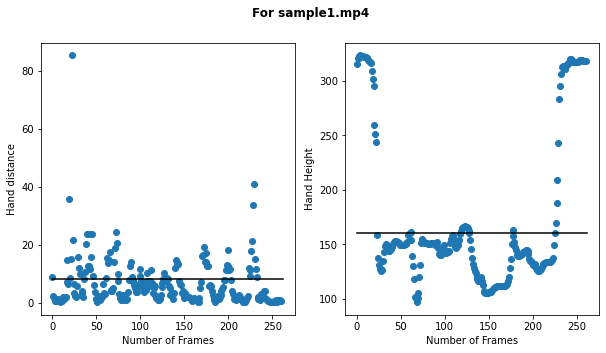

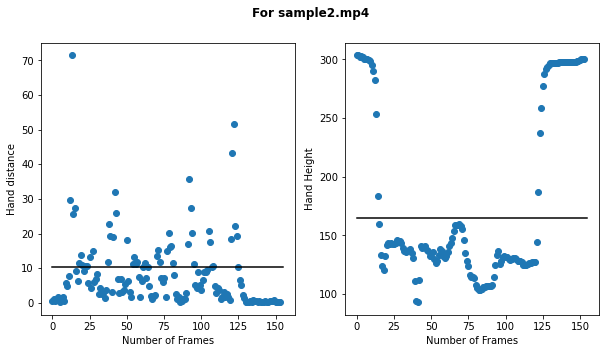

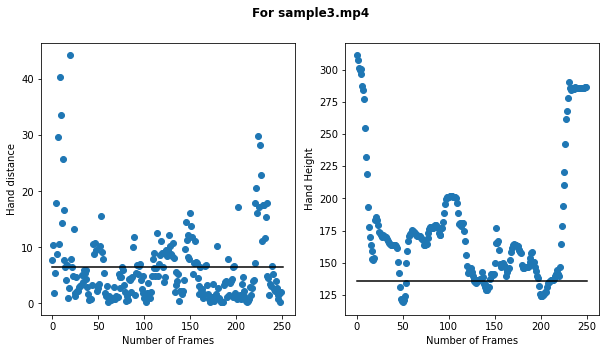

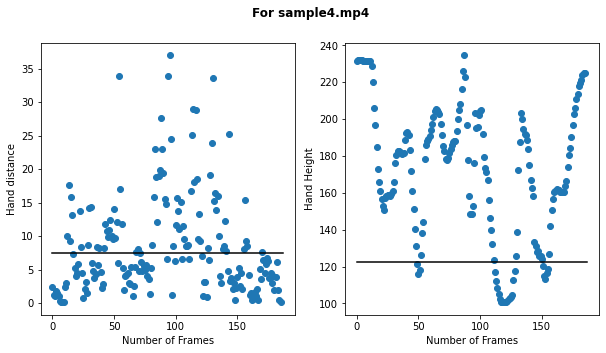

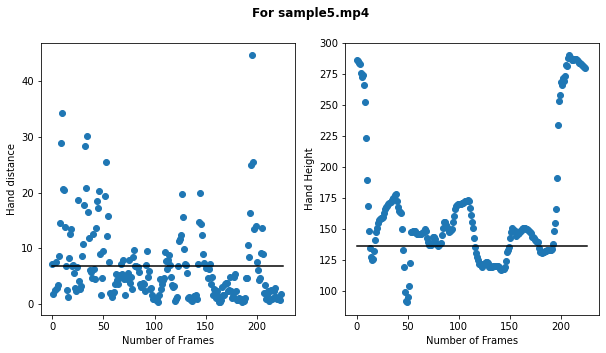

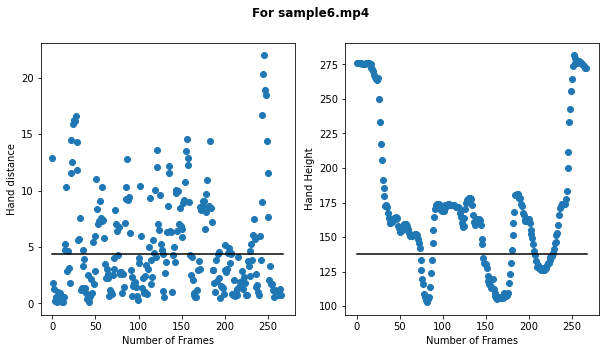

In [6]:
if __name__=="__main__":
    path = "../../KT Session 2/Output/"
    videoList = os.listdir(path)
    
    for videoFileName in videoList:
        # Calculating parameters of the video
        videoPath = os.path.join(path, videoFileName)
        video = cv2.VideoCapture(videoPath)
        (handDistance, handHeight, frameCount) = KFEParameters(videoPath)
        (handDistThresh, handHeightThresh) = plotGraphs(videoFileName, frameCount, handDistance, handHeight)
        
        # Creating the output video
        outputVideoPath = os.path.join("../../KT Session 2/Output/", videoFileName.split(".")[0] + "_output.mp4")
        outputVideoDim = (int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(video.get(cv2.CAP_PROP_FRAME_WIDTH)))
        outputVideo = cv2.VideoWriter(outputVideoPath, cv2.VideoWriter_fourcc("m", "p", "4", "v"), video.get(cv2.CAP_PROP_FPS), outputVideoDim)
        frameIndex = 0
        outputFrameCount = 0
        
        # Adding relevant frames of the original video to the output video
        while True:
            success, frame = video.read()
            if success:
                if(handDistance[frameIndex-1]>handDistThresh):
                    outputVideo.write(frame)
                elif(handHeight[frameIndex-1]>handHeightThresh):
                    outputVideo.write(frame)
                outputFrameCount+=1
                frameIndex+=1
            else:
                break
                
        # Creating dictionary to store the necessary parameters
        outputVideo.release()
        outputFileSummary = {}
        outputFileSummary["Filename"] = videoFileName
        outputFileSummary["Hand_Height"] = handHeight
        outputFileSummary["Hand_Distance"] = handDistance
        outputFileSummary["Initial_Frame_Count"] = frameCount
        outputFileSummary["Post_KFS_Frame_Count"] = outputFrameCount
        outputFileSummary["Percentage_Reduction"] = round(((frameCount-outputFrameCount)/frameCount)*100, 2)
        outputFileSummary["Hand_Height_Threshold_Value"] = handHeightThresh
        outputFileSummary["Hand_Distance_Threshold_Value"] = handDistThresh 
        
        # Adding the parameters onto the JSON file
        outputFilePath = os.path.join("../../KT Session 2/Output/", videoFileName.split(".")[0] + "_output.json")
        with open(outputFilePath, "w") as fp:
            fp.write(json.dumps(outputFileSummary))
